In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,precision_score,recall_score,precision_recall_curve,roc_curve,roc_auc_score,f1_score,average_precision_score,auc
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from xgboost import XGBClassifier

In [ ]:
link="https://www.drive.google.com/uc?export=download&id=1nW2d5VHQrT59J1lV2KLnwrLM54yXEilz"
data=pd.read_csv(link)
data.drop(["Unnamed: 0",'id'],axis=1,inplace=True)
data.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.012996,tcp,-,FIN,16,18,1540,1644,2539.242797,31,...,1,6,0,0,0,5,7,0,Normal,0
1,0.004119,tcp,-,FIN,12,12,1064,2260,5583.879675,31,...,1,1,0,0,0,3,8,0,Normal,0
2,0.000988,udp,dns,CON,2,2,146,178,3036.437382,31,...,1,2,0,0,0,7,2,0,Normal,0
3,3.415787,tcp,ssh,FIN,230,238,24344,29556,136.718127,31,...,1,1,0,0,0,4,1,0,Normal,0
4,0.193943,tcp,-,FIN,72,74,4238,63618,747.642372,31,...,1,5,0,0,0,6,12,0,Normal,0


<h1>Data Preparation</h1>

In [ ]:
X=data.drop("attack_cat",axis=1)
y=data["attack_cat"]
unique_y=y.unique()
def fun(x):
  c=0
  for i in unique_y:
    if i==x:
      return c
    c+=1
y_coded=pd.Series(map(fun,y),dtype='int32')
cols=['proto','service','state']
X=pd.concat([X.drop(cols,axis=1),pd.get_dummies(X)],axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y_coded,test_size=0.2,random_state=42)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
pd.concat([pd.Series(np.unique(y_coded)),pd.Series(y.unique()),pd.Series(np.unique(y_test))],axis=1)#To ensure all labeling is correct

,0,1,2
0,0,Normal,0
1,1,Backdoor,1
2,2,Analysis,2
3,3,Fuzzers,3
4,4,Shellcode,4
5,5,Reconnaissance,5
6,6,Exploits,6
7,7,DoS,7
8,8,Worms,8
9,9,Generic,9


In [ ]:
def evaluate_model(model,X_test,y_test):
    y_pred=model.predict(X_test)
    y_scores=model.predict_proba(X_test)
    custom_roc_auc(model,y_test,y_pred,y_scores)
    precision_recall_f1(model,y_test,y_pred,y_scores)
    custom_confusion_matrix(model,y_test,y_pred,y_scores)

def custom_roc_auc(model,y_test,y_pred,y_scores):
    global y_test_binarized,y_pred_probabilities
    y_test_binarized=label_binarize(y_test,classes=np.unique(y_test))
    y_pred_probabilities=model.predict_proba(X_test)
    auc_scores=dict()
    for i in range(y_test_binarized.shape[1]):
      auc_scores[f'Class {unique_y[i]} AUC']=roc_auc_score(y_test_binarized[:,i],y_pred_probabilities[:,i])
    print("AUC Scores (One vs Rest strategy)")
    for class_label,auc_score in auc_scores.items():
      print(f"{class_label}: {auc_score:.2}")
    fpr, tpr, roc_auc = {}, {}, {}
    plt.figure(figsize=(10,8))
    for i in range(y_test_binarized.shape[1]):
      fpr[i],tpr[i],_=roc_curve(y_test_binarized[:,i],y_pred_probabilities[:,i])
      roc_auc[i]=auc(fpr[i],tpr[i])
      plt.plot(fpr[i],tpr[i],lw=2,label=f'Class {unique_y[i]} (AUC={roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Multiclass ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def precision_recall_f1(model,y_test,y_pred,y_scores):
    predictions=model.predict(X_test)
    f1_macro=f1_score(y_test,predictions,average='macro')
    f1_micro=f1_score(y_test,predictions,average='micro')
    f1_weighted=f1_score(y_test,predictions,average='weighted')
    print(f"F1 Score Macro: {f1_macro}")
    print(f"F1 Score Micro: {f1_micro}")
    print(f"F1 Score Weighted: {f1_weighted}")
    plt.figure(figsize=(10, 8))
    for i in range(y_test_binarized.shape[1]):
        precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_probabilities[:, i])
        avg_precision = average_precision_score(y_test_binarized[:, i], y_pred_probabilities[:, i])
        plt.plot(recall, precision, lw=2, label=f'Class {unique_y[i]} (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Multiclass Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def custom_confusion_matrix(model,y_test,y_pred,y_scores):
    y_pred=model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, linewidth=0.5,
                xticklabels=unique_y, yticklabels=unique_y)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()


Model Name: Random Forest
Accuracy: 0.8223798441021094
AUC Scores (One vs Rest strategy)
Class Normal AUC: 1.0
Class Backdoor AUC: 0.9
Class Analysis AUC: 0.92
Class Fuzzers AUC: 0.98
Class Shellcode AUC: 0.99
Class Reconnaissance AUC: 0.97
Class Exploits AUC: 0.94
Class DoS AUC: 0.9
Class Worms AUC: 0.99
Class Generic AUC: 1.0


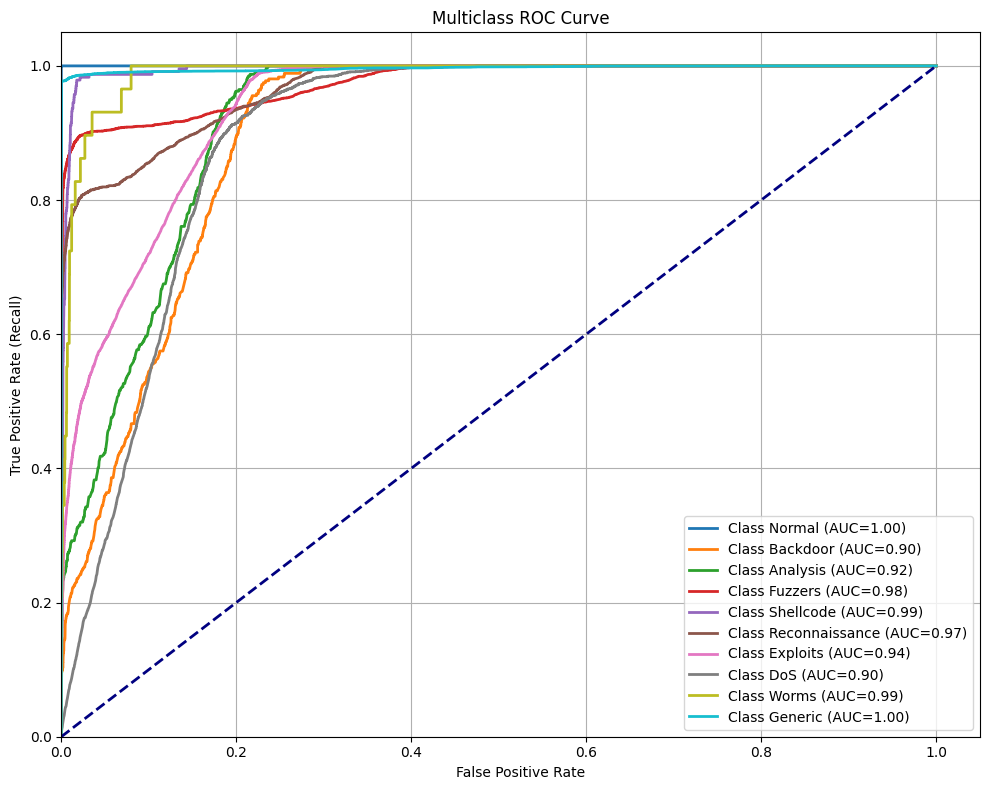

F1 Score Macro: 0.5299952181613977
F1 Score Micro: 0.8223798441021094
F1 Score Weighted: 0.7830496535403699


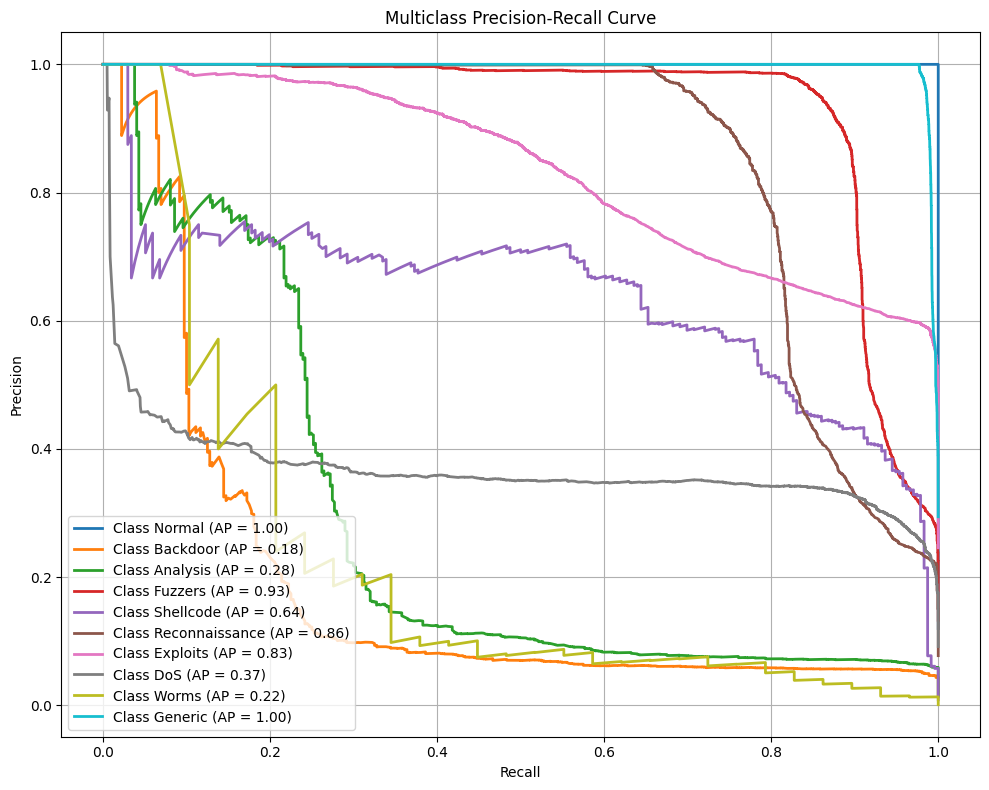

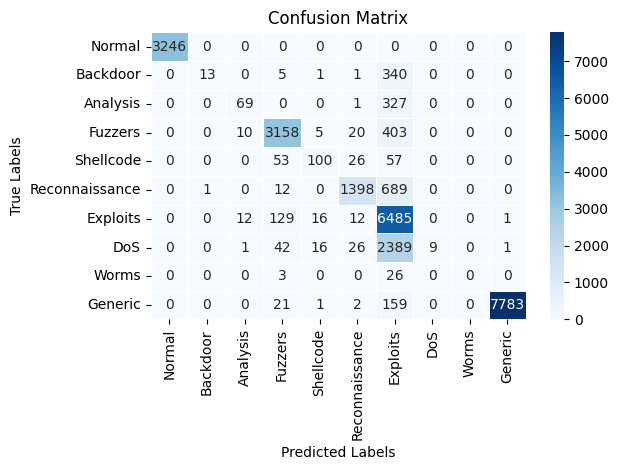

Model Name: XG Boost
Accuracy: 0.8384498873249843
AUC Scores (One vs Rest strategy)
Class Normal AUC: 1.0
Class Backdoor AUC: 0.9
Class Analysis AUC: 0.92
Class Fuzzers AUC: 0.98
Class Shellcode AUC: 1.0
Class Reconnaissance AUC: 0.97
Class Exploits AUC: 0.95
Class DoS AUC: 0.91
Class Worms AUC: 1.0
Class Generic AUC: 1.0


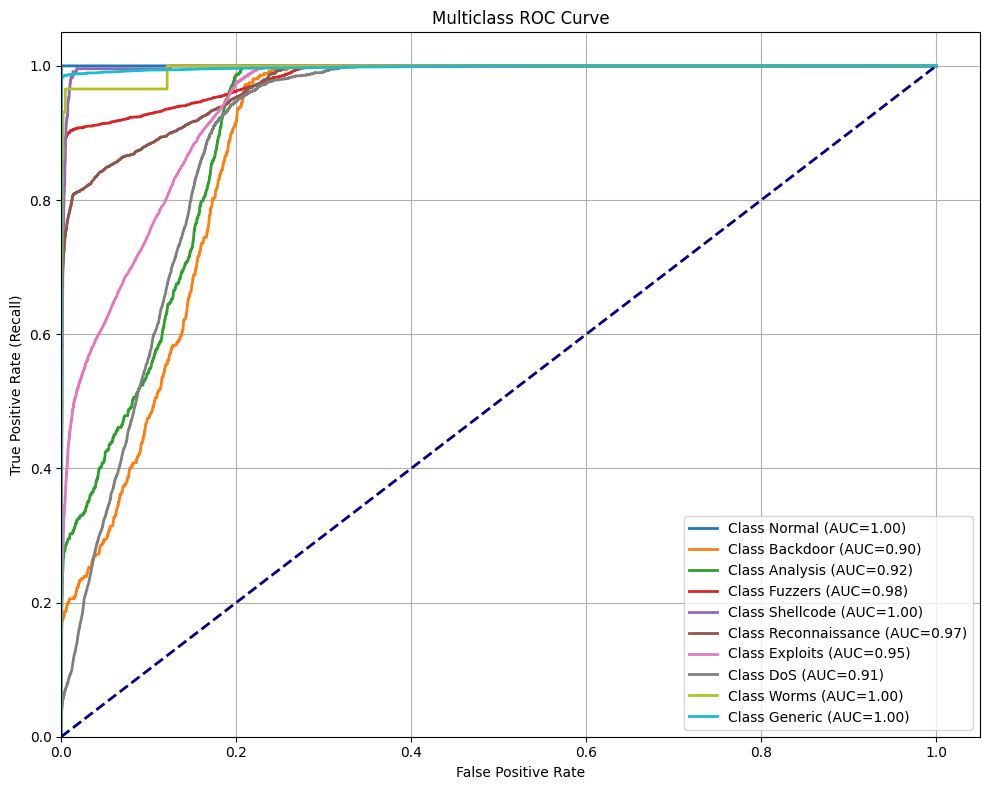

F1 Score Macro: 0.6373751419907064
F1 Score Micro: 0.8384498873249843
F1 Score Weighted: 0.8085373492997849


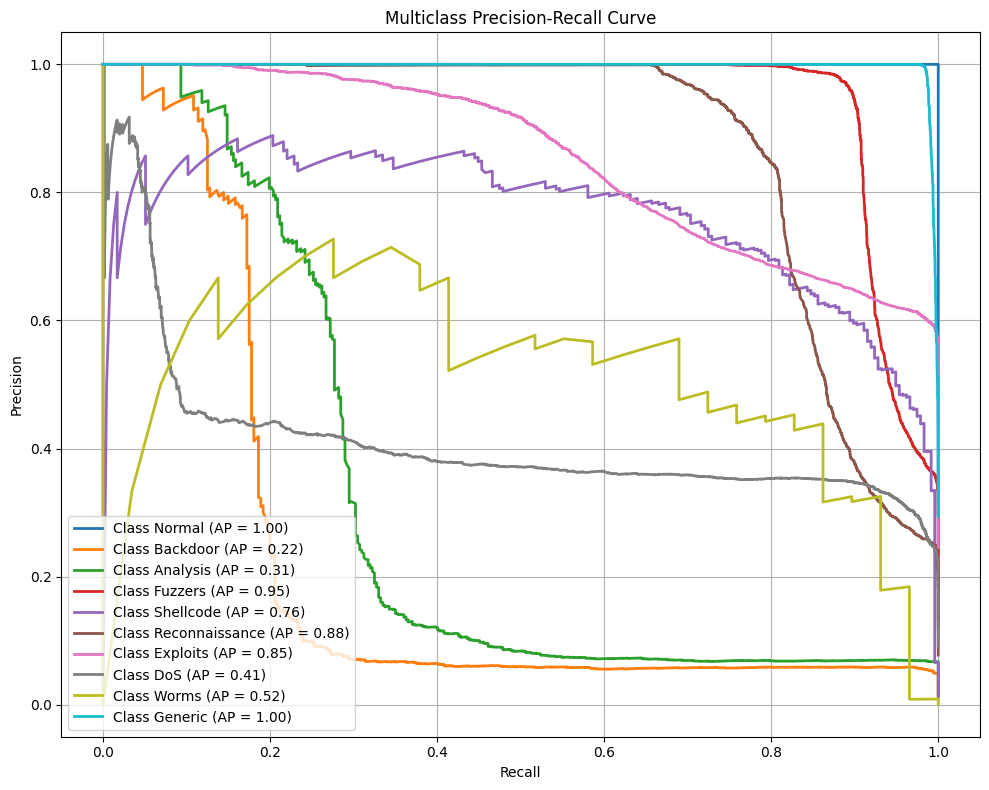

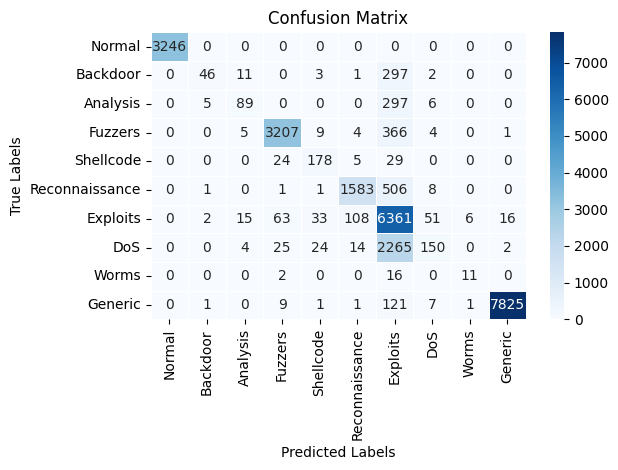

Model Name: Ada Boost
Accuracy: 0.7723964682847537
AUC Scores (One vs Rest strategy)
Class Normal AUC: 1.0
Class Backdoor AUC: 0.84
Class Analysis AUC: 0.87
Class Fuzzers AUC: 0.87
Class Shellcode AUC: 0.95
Class Reconnaissance AUC: 0.85
Class Exploits AUC: 0.85
Class DoS AUC: 0.86
Class Worms AUC: 0.97
Class Generic AUC: 0.99


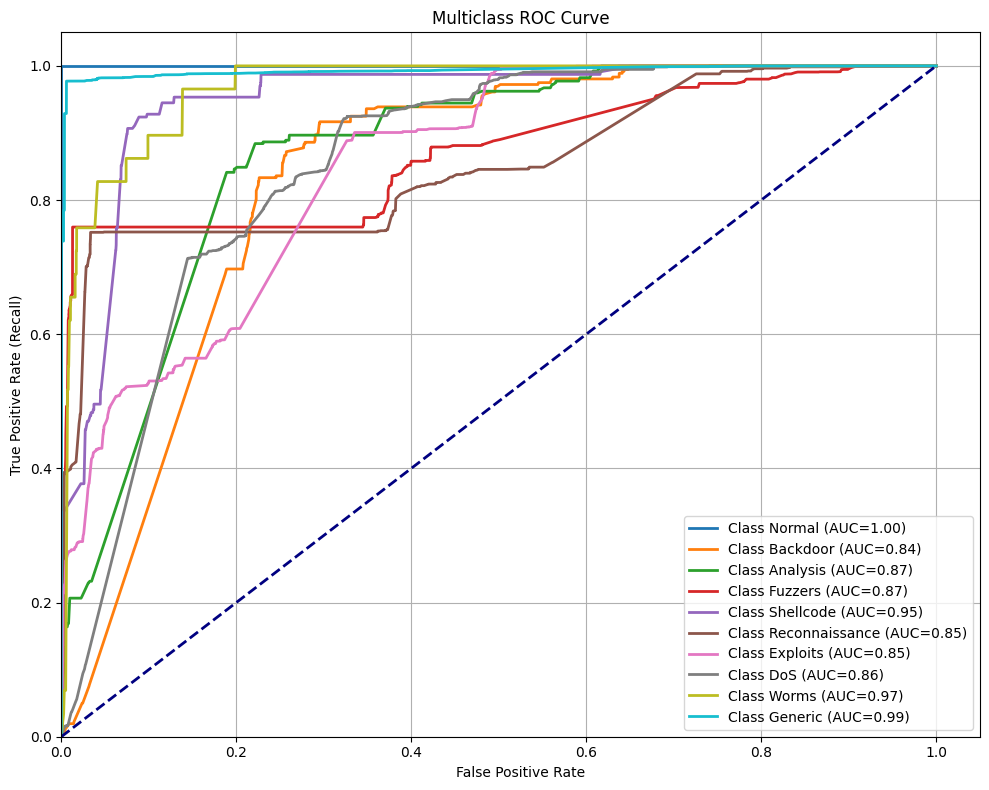

F1 Score Macro: 0.40874430288442615
F1 Score Micro: 0.7723964682847537
F1 Score Weighted: 0.7322469470686099


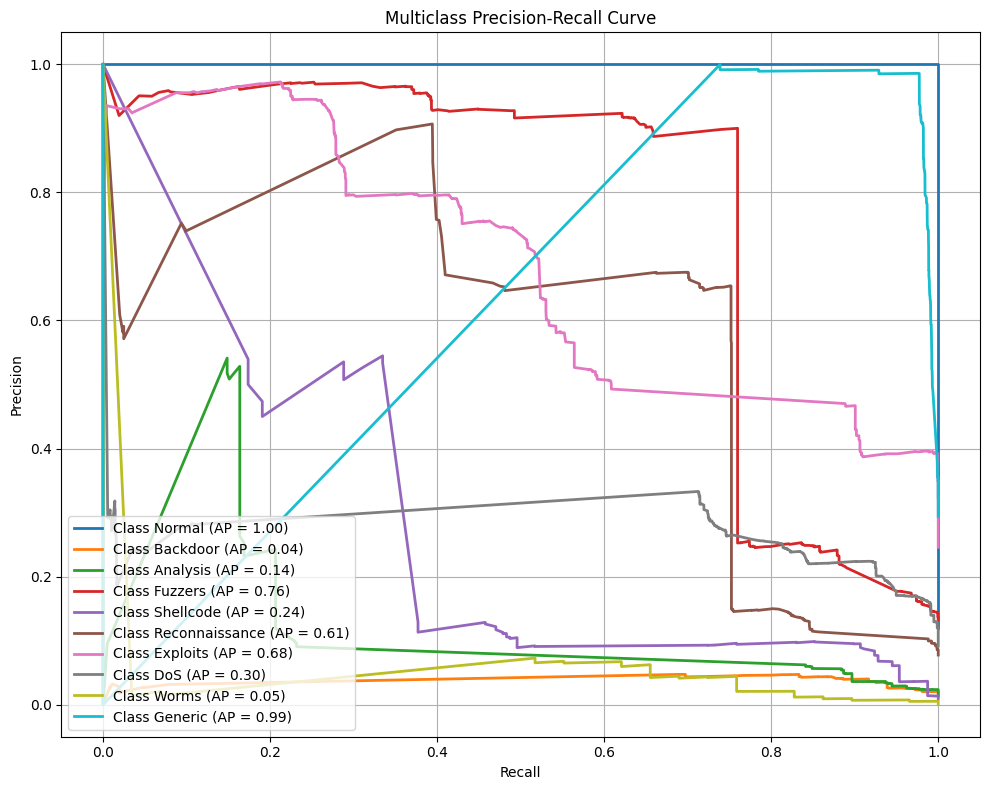

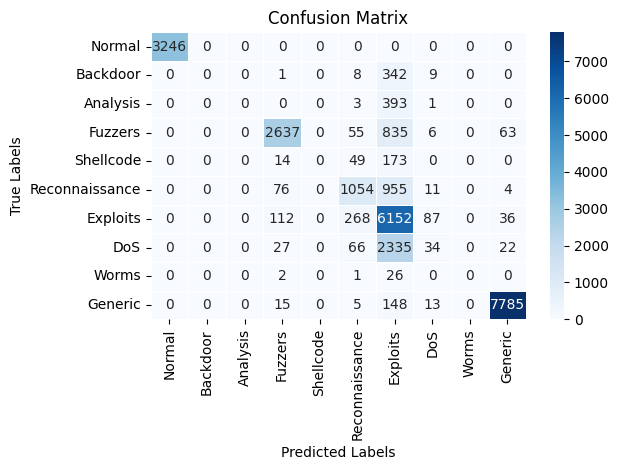

In [ ]:
models={'Random Forest':RandomForestClassifier(n_estimators=100, max_depth=20, min_impurity_decrease=0.0001, min_samples_split=10),
        'XG Boost':XGBClassifier(n_estimators=50),
        'Ada Boost':AdaBoostClassifier()
}
for name,model in models.items():
    model.fit(X_train,y_train)
    print("Model Name:",name)
    print(f"Accuracy: {np.mean(model.predict(X_test)==y_test)}")
    evaluate_model(model,X_test,y_test)


The lack of certain classes in the test set indicates a bad train-test split.

In [ ]:
best_model=models['XG Boost']
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 40))
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), np.array(X_test.columns)[indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from XGBoost')
plt.tight_layout()
plt.show()

KeyError: 'xgb'